# Try Reddit API

The goal is to understand the parameters and limitations of the api and check if it could be used to get crypto news programatically.

In [1]:
import os
os.chdir('../')

In [2]:
import praw
import yaml
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from settings import REDDIT_CREDS

## Import data

Get credentials.

In [3]:
# has to follow this rules: https://github.com/reddit-archive/reddit/wiki/API

client_name = "news_bot"
client_version = "0.1.0"
user_name = os.getenv('REDDIT_USERNAME')
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_SECRET')

# Override if creds are in yaml file
if os.path.isfile(REDDIT_CREDS):
    with open(REDDIT_CREDS) as stream:
        creds = yaml.safe_load(stream)
    user_name = creds['REDDIT_USERNAME']
    client_id = creds['REDDIT_CLIENT_ID']
    client_secret = creds['REDDIT_SECRET']

In [4]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=f"praw:{client_name}:{client_version} (by /u/{user_name})",
)

In [5]:
print(reddit.read_only)

True


In [6]:
data_records = []

for submission in reddit.subreddit("CryptoCurrency").top("week", limit=None):
    data_records.append({
        'id': submission.id,
        'created_utc': datetime.fromtimestamp(submission.created_utc),
        'author': submission.author,
        'title': submission.title,
        'name': submission.name,
        'link_flair_text': submission.link_flair_text,
        'selftext': submission.selftext,
        'url': submission.url,
        'score': submission.score, 
        'upvote_ratio': submission.upvote_ratio,
        'distinguished': submission.distinguished,
    })

news_df = pd.DataFrame.from_records(data_records)
print(f"Submissions retrieved: {news_df.shape[0]}")

Submissions retrieved: 1000


In [7]:
news_df.head()

,id,created_utc,author,title,name,link_flair_text,selftext,url,score,upvote_ratio,distinguished
0,ss8ohv,2022-02-14 06:40:59,Blitzwarden,Hacker could’ve printed unlimited ‘Ether’ but ...,t3_ss8ohv,GENERAL-NEWS,,https://protos.com/ether-hacker-optimism-ether...,13033,0.92,None
1,srr32t,2022-02-13 14:44:18,RefugeeDutch_Syrian,'White Hat hacker' saves Coinbase from possibl...,t3_srr32t,GENERAL-NEWS,"In the nick of time, a gigantic crisis for the...",https://www.reddit.com/r/CryptoCurrency/commen...,9132,0.93,None
2,ssajk9,2022-02-14 08:25:03,Acceptable_Novel8200,"Snowden : Coinbase spending $16,000,000 on a S...",t3_ssajk9,EXCHANGES,Edward Snowden's tweet on Coinbase's superbowl...,https://www.reddit.com/r/CryptoCurrency/commen...,6241,0.96,None
3,sp71mt,2022-02-10 08:49:24,rmansd619,What its like currently holding ADA.,t3_sp71mt,COMEDY,Hodling ADA is like you're eating at a 5 star...,https://www.reddit.com/r/CryptoCurrency/commen...,6078,0.84,None
4,st424u,2022-02-15 09:23:17,Vimmington,FINALLY got all my crypto off Robinhood. You s...,t3_st424u,ADVICE,I'll admit it: I've kept a large sum of my cry...,https://www.reddit.com/r/CryptoCurrency/commen...,5756,0.91,None


## Some statistics

### Score

<AxesSubplot:>

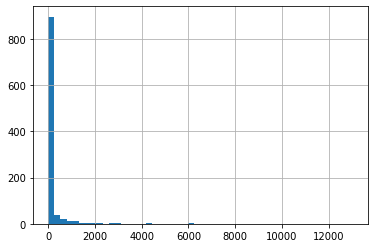

In [8]:
news_df.score.hist(bins=50)

In [9]:
news_df.score.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0        3.0
0.1        7.0
0.2        8.0
0.3       10.0
0.4       14.0
0.5       19.0
0.6       28.0
0.7       50.0
0.8      100.0
0.9      280.4
1.0    13033.0
Name: score, dtype: float64

### Length of title
Number of characters.

<AxesSubplot:>

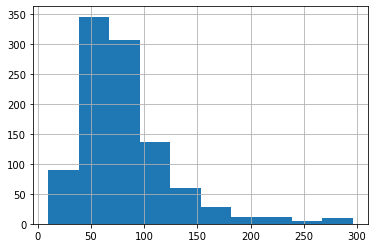

In [10]:
news_df.title.apply(len).hist()

### Length of selftext
Number of characters in **non-empty strings**.

<AxesSubplot:>

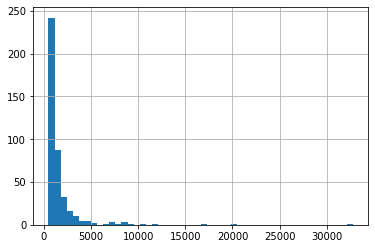

In [11]:
selftext_len = news_df.selftext.apply(len)
selftext_len[selftext_len > 0].hist(bins=50)

In [12]:
selftext_len[selftext_len > 0].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      482.0
0.1      568.2
0.2      661.4
0.3      769.6
0.4      859.0
0.5      975.0
0.6     1159.2
0.7     1397.2
0.8     1777.2
0.9     2730.8
1.0    32759.0
Name: selftext, dtype: float64

### Dates

<AxesSubplot:xlabel='date_created_utc'>

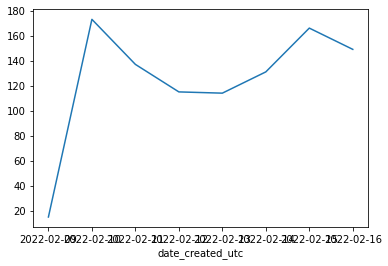

In [13]:
news_df["date_created_utc"] = news_df.created_utc.dt.date
news_df.groupby("date_created_utc").title.count().plot()

## Data cleansing

Keep only articles with high scores.

In [14]:
score_th = 20

news_df = news_df[news_df.score > score_th].copy()

In [15]:
print(f"Submissions selected: {news_df.shape[0]}")

Submissions selected: 475


# Text classification

## Titles

Prepare list.

In [16]:
news_list = list(news_df.title)

Transform text to vectors.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(news_list)

K-means clustering.

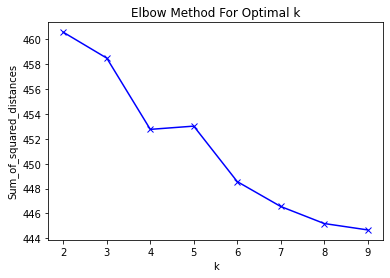

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
true_k = 4
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
km_model.fit(X)
labels = km_model.labels_

news_df['cluster'] = labels
news_df.groupby('cluster').title.count()

cluster
0    133
1    160
2    152
3     30
Name: title, dtype: int64

Top words in each cluster.

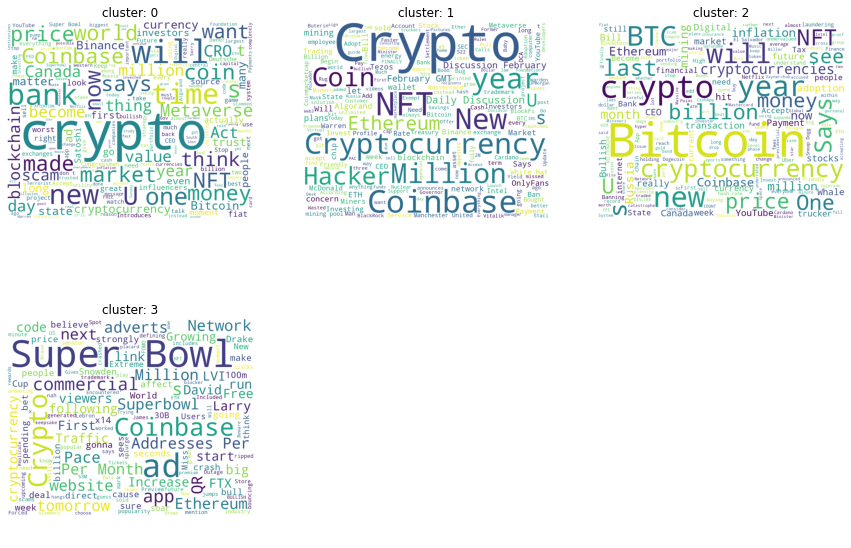

In [20]:
from wordcloud import WordCloud

# prepare subplots
clusters = list(news_df.cluster.unique())
plot_cols = 3
plot_rows = int(np.ceil(len(clusters) / plot_cols))
fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(15,10))

for cluster in clusters:
    col = cluster % plot_cols
    row = int(cluster/plot_cols)
    
    corpus = ' '.join(news_df['title'][news_df['cluster'] == cluster])
    ax[row,col].imshow(WordCloud(width = 1000,
                             height = 800,
                             background_color ='white', 
                             min_font_size = 10).generate(corpus))
    ax[row,col].set_title(f"cluster: {cluster}")
for axrow in ax:
    for axelm in axrow:
        axelm.axis("off")
    
plt.show()

**Reading recomendations:** Top submission in each cluster.

In [21]:
news_df['url'] = news_df['id'].apply(lambda s: f"http://redd.it/{s}")

print(
    news_df[['cluster', 'score', 'upvote_ratio', 'url', 'title']]\
        .sort_values(['cluster', 'score'])\
        .groupby('cluster')\
        .tail(1)\
        .set_index('cluster')
)

         score  upvote_ratio                    url  \
cluster                                               
0         4279          0.85  http://redd.it/sssr25   
1        13033          0.92  http://redd.it/ss8ohv   
2         6078          0.84  http://redd.it/sp71mt   
3         6241          0.96  http://redd.it/ssajk9   

                                                     title  
cluster                                                     
0        Canada's Trudeau Enacts Emergencies Act, and C...  
1        Hacker could’ve printed unlimited ‘Ether’ but ...  
2                     What its like currently holding ADA.  
3        Snowden : Coinbase spending $16,000,000 on a S...  


## Selftext

In [22]:
# only submissions with self_text
selftext_df = news_df[news_df.selftext.apply(len) > 0].copy()
selftext_df.shape

(226, 13)

Prepare list.

In [23]:
selftext_list = list(selftext_df.selftext)

Transform text to vectors.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(selftext_list)

K-means clustering.

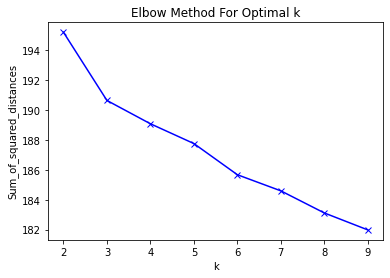

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [26]:
true_k = 6
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
km_model.fit(X)
labels = km_model.labels_

selftext_df['cluster'] = labels
selftext_df.groupby('cluster').title.count()

cluster
0    85
1    14
2     7
3    12
4    90
5    18
Name: title, dtype: int64

Top words in each cluster.

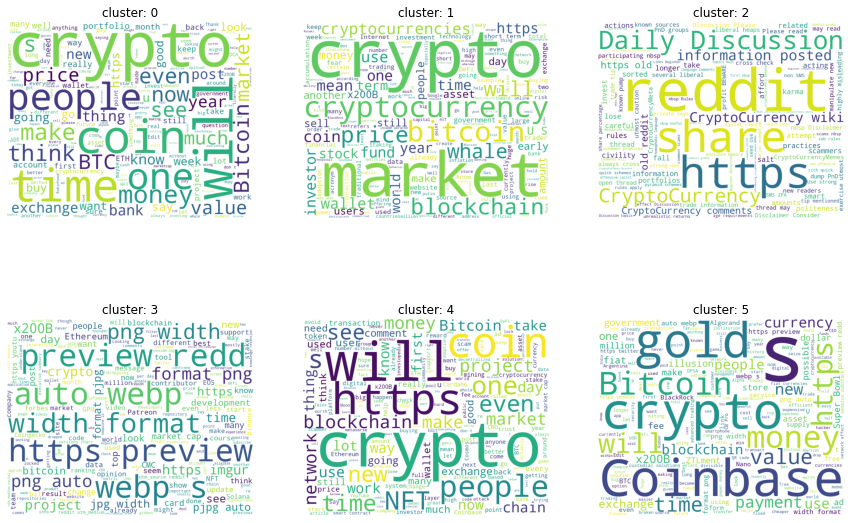

In [27]:
from wordcloud import WordCloud

# prepare subplots
clusters = list(selftext_df.cluster.unique())
plot_cols = 3
plot_rows = int(np.ceil(len(clusters) / plot_cols))
fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(15,10))

for cluster in clusters:
    col = cluster % plot_cols
    row = int(cluster/plot_cols)
    
    corpus = ' '.join(selftext_df['selftext'][selftext_df['cluster'] == cluster])
    ax[row,col].imshow(WordCloud(width = 1000,
                             height = 800,
                             background_color ='white', 
                             min_font_size = 10).generate(corpus))
    ax[row,col].set_title(f"cluster: {cluster}")
for axrow in ax:
    for axelm in axrow:
        axelm.axis("off")
    
plt.show()

**Reading recomendations:** Top submission in each cluster.

In [28]:
selftext_df['url'] = selftext_df['id'].apply(lambda s: f"http://redd.it/{s}")
print(
    selftext_df[['cluster', 'score', 'upvote_ratio', 'url', 'title']]\
        .sort_values(['cluster', 'score'])\
        .groupby('cluster')\
        .tail(1)\
        .set_index('cluster')
)

         score  upvote_ratio                    url  \
cluster                                               
0         6078          0.84  http://redd.it/sp71mt   
1         2144          0.87  http://redd.it/ssgenk   
2          182          0.92  http://redd.it/ssox48   
3         4279          0.89  http://redd.it/stlxai   
4         2802          0.97  http://redd.it/sotn2r   
5         9132          0.93  http://redd.it/srr32t   

                                                     title  
cluster                                                     
0                     What its like currently holding ADA.  
1        The incoming hyper inflation will create an ex...  
2             Daily Discussion - February 15, 2022 (GMT+0)  
3        Crypto isn't the only thing that is down these...  
4        Friendly Reminder: Be extra careful with new c...  
5        'White Hat hacker' saves Coinbase from possibl...  
